---
title: "Quality Control: Relatedness & Population Stratification"
author:
    - name: Conor O'Hare
    - name: Samuele Soraggi
      orcid: 0000-0002-1159-5535
      email: samuele@birc.au.dk
    - name: Alba Refoyo Martinez
      orcid: 0000-0002-3674-4007
      email: alba.martinez@sund.ku.dk   
---


---
format:
  html:
   theme: default
   number-sections: true
   code-fold: false
   self-contained: false
   toc: true
   highlight-style: pygments
  ipynb:
    toc: true
    number-sections: false
bibliography: references/references_4.bib
---

::: {.callout-note title="Important notes for this notebook" icon=false}

As we have already mentioned, quality control (QC) analyses are crucial to ensure the reliability and validity of the results. In this section, we will explore confounding factors in GWAS that can lead to spurious associations if not properly controlled, including: 

-  Relatedness  
- Population Stratification/Structure

## Learning outcomes

- **Discuss** confounding factors that lead to spurious associations
- **Detect** related individuals
- **Identify** population substructure
- **Correct** for population stratification 

## How to make this notebook work

In this notebook, we will both use `R` and `bash command line` programming languages. Remember to **change the kernel** whenever you transition from one language to the other (`Kernel --> Change Kernel`) indicated by the languages' images.
* We will first run `Bash` commands.  
  
<img src="Images/bash.png" alt="Bash" width="80"> Choose the Bash kernel

:::

## 4.1 Relatedness

Relatedness refers to the presence of genetically related individuals in a study sample, which can introduce confounding factors into association analyses. Most statistical methods assume that samples are independent, so including related individuals, such as siblings, would violate this assumption. To address this, a common quality control step involves identifying and managing relatedness to ensure the genomes in the dataset are no more similar than expected for unrelated individuals. Properly handling relatedness is essential to maintain the validity of the study's findings.

While all humans share some genetic relatedness, the degree of relatedness varies among individuals. In genome-wide association studies (GWAS), these variations must be accounted for to avoid biasing the statistical associations between genotypes and phenotypes. **Cryptic relatedness** (genetic relatedness of individuals not expected to be in a family relationship) can interfere with the association analysis [@voight2005confounding]. In a **family-based study** (e.g., parent-offspring), you do not need to remove related pairs, but the statistical analysis should account for family relatedness. However, for a **population-based study**, we suggest using a $\hat{\pi}$ threshold of 0.2. $\hat{\pi}$ computed as P(IBD = 2) + 0.5 × P(IBD = 1), where P denotes probablility. $\hat{\pi}$ ranges between 0 and 1, where 0 indicates no relationship and higher values indicate closer relatedness.

<img src="Images/bash.png" alt="Bash" width="40"> We use `ln -sf` to link the data folder and create a directory for output files. 

In [2]:
ln -sf ../Data
mkdir -p Results/GWAS4

### 4.1.1 Analysis

We will make use of the independent SNPs for our analysis (generated in the previous section). It is also essential to check the datasets you analyze for cryptic relatedness. Assuming a random population sample, we will exclude all individuals above the $\hat{\pi}$ threshold of 0.2 in this tutorial. 

The HapMap dataset is known to contain parent-offspring relationships. The following commands will help visualise these parent-offspring relations, using the $z$ values. $z_0$ indicates the fraction of the genome with no alleles identical-by-descent (IBD) with another genome and $z_1$ with 1 allele IBD.

The commands below use PLINK to calculate the relationship between individuals. A threshold on relatedness can be set with `--min` and `--max` options (it will be in the exercise afterwards).

In [3]:
plink --bfile Results/GWAS3/HapMap_3_r3_7 --extract Results/GWAS3/indepSNP.prune.in --genome --out Results/GWAS4/pihat --silent

The table from PLINK contains various IDs in the first columns, then 
- `RT` Relationship
- `EZ`	IBD sharing expected value, based on just .fam/.ped relationship
- `Z0`	P(IBD=0)
- `Z1`	P(IBD=1)
- `Z2`	P(IBD=2)
- `PI_HAT`	Proportion IBD, i.e. P(IBD=2) + 0.5*P(IBD=1)
- `PHE`	Pairwise phenotypic code (1, 0, -1 = AA, AU, and UU pairs, respectively)
- `DST`	IBS distance, i.e. (IBS2 + 0.5*IBS1) / (IBS0 + IBS1 + IBS2)
- `PPC`	IBS binomial test
- `RATIO` : IBS0 SNP ratio (expected value 2)

The specific IBD coefficients (PI_HAT, Z0, Z1, Z2) in the output file are used to infer these relationships. PI_HAT represents the proportion of IBD sharing, and Z0, Z1, and Z2 represent the probabilities that a pair of individuals share 0, 1, or 2 alleles IBD, respectively. The combination of these values helps to classify the relationship into one of the above categories.

For the relationships `RT`, you can have:

- `PO` (Parent-Offspring): This indicates a parent-offspring relationship. The expected IBD sharing for such a pair is 50%.
- `FS` (Full Siblings): This indicates a full sibling relationship. Full siblings are expected to share 50% of their genome IBD, but the pattern of sharing (i.e., segments shared by descent) differs from that of a parent-offspring pair.
- `HS` (Half Siblings): This indicates a half sibling relationship, where the individuals share one parent. They are expected to share about 25% of their genome IBD.
- `UN` (Unrelated): This label indicates that the pair of individuals is inferred to be unrelated. They share little to no IBD segments, which is expected for unrelated individuals in large populations.
- `AV` (Avuncular): This indicates an avuncular relationship (e.g., uncle/aunt to niece/nephew), where the expected IBD sharing is around 25%.
- `GG` (Grandparent-Grandchild): This label indicates a grandparent-grandchild relationship, with expected IBD sharing of about 25%.
- `CO` (Cousin): This label is used for cousin relationships, where the expected IBD sharing is about 12.5%.
- `OT` (Other): For more distant relationships or complex kinship structures, this label might be used when none of the primary categories apply clearly.

:::{.callout-important title="Stop - Read - Solve"}

- What assumption in association studies is violated when individuals are related?
- How would you recognize if the same person is included twice in your dataset?
- Are there any individuals in your dataset who are closely related?

:::

:::{.callout-tip title="Solution" collapse=true}

If you have related individual, you will lose the indipendence of individuals at each SNP. This is a problem, because many models used in GWAS analysis do not include handling family relationships.

To find any duplicated individual in the data, simply use `uniq` on the `fam` file of the data, and count each occurrence. Then find a line with  anumber larger than 1. There is no output, so individuals are unique.

In [20]:
cut -f2 -d' ' Results/GWAS3/HapMap_3_r3_7.fam | uniq -c |  grep -v "1 "

: 1

We can visualize the `PI_HAT` parameter, which is in column 10 of the `genome` file created by PLINK

In [21]:
cat Results/GWAS4/pihat.genome | head -5

   FID1     IID1   FID2     IID2 RT    EZ      Z0      Z1      Z2  PI_HAT PHE       DST     PPC   RATIO
   1328  NA06989   1377  NA11891 UN    NA  0.9891  0.0109  0.0000  0.0055   1  0.720373  0.4063  1.9840
   1328  NA06989   1349  NA11843 UN    NA  0.9846  0.0154  0.0000  0.0077   0  0.718050  0.0223  1.8707
   1328  NA06989   1330  NA12341 UN    NA  0.9649  0.0351  0.0000  0.0176   1  0.721260  0.2259  1.9501
   1328  NA06989   1344  NA10850 UN    NA  0.9860  0.0129  0.0011  0.0075   0  0.721665  0.6441  2.0250


We can see which individuals have a parameter larger than 0.2. There are a lot of parent-offspring (PO) relationships which have a parameter around 0.5, plus unrelated (UN) individual which stands out as having a lot of relatedness.

In [22]:
awk '{ if ($10 > 0.2) print }' Results/GWAS4/pihat.genome

   FID1     IID1   FID2     IID2 RT    EZ      Z0      Z1      Z2  PI_HAT PHE       DST     PPC   RATIO
   1377  NA11891   1377  NA10865 PO   0.5  0.0015  0.9985  0.0000  0.4993   0  0.823436  1.0000 1808.0000
   1349  NA11843   1349  NA10853 PO   0.5  0.0021  0.9901  0.0077  0.5028  -1  0.824968  1.0000 928.5000
   1330  NA12341   1330  NA12335 PO   0.5  0.0000  1.0000  0.0000  0.5000   0  0.822813  1.0000 923.0000
   1463  NA12877   1463  NA12890 PO   0.5  0.0000  1.0000  0.0000  0.5000   0  0.823210  1.0000 922.7500
   1463  NA12877   1463  NA12889 PO   0.5  0.0144  0.9797  0.0059  0.4958   0  0.823374  1.0000 146.4800
   1418  NA12275   1418  NA10836 PO   0.5  0.0024  0.9958  0.0018  0.4997  -1  0.823889  1.0000      NA
  13291  NA06986  13291  NA06997 PO   0.5  0.0016  0.9954  0.0030  0.5007  -1  0.824182  1.0000 1837.5000
   1418  NA12272   1418  NA10837 PO   0.5  0.0016  0.9922  0.0062  0.5023  -1  0.824750  1.0000 1829.5000
   1424  NA10845   1424  NA11930 PO   0.5  0.0016  0.9

Now this is a hell of a long list already, so we can maybe count how many lines there are to count the individuals (minus 1, the header line)

In [23]:
awk '{ if ($10 > 0.2) print }' Results/GWAS4/pihat.genome | wc -l

94


:::

---------------

<img src="Images/R.png" alt="R" width="40"> Once we have calculated the pihat values between individuals, let's plot the z-values against each other:

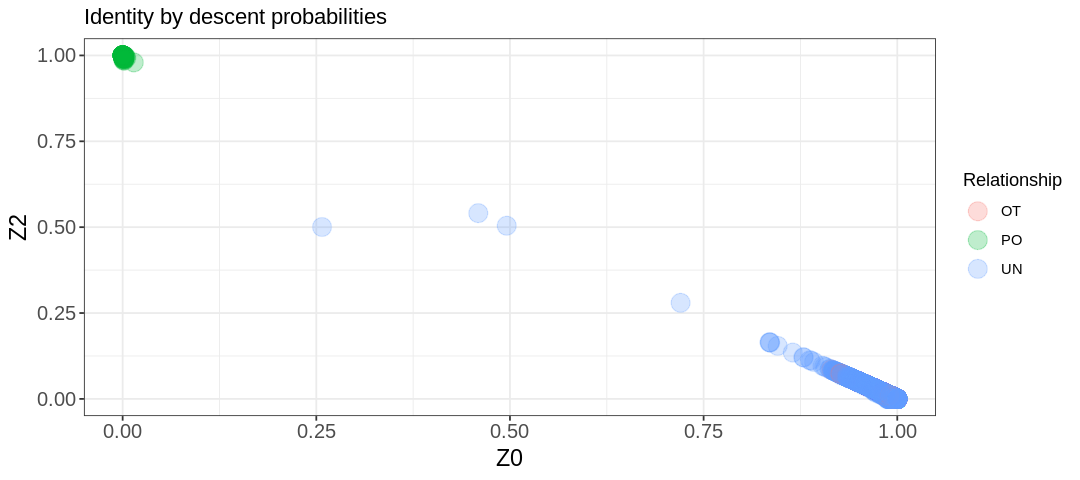

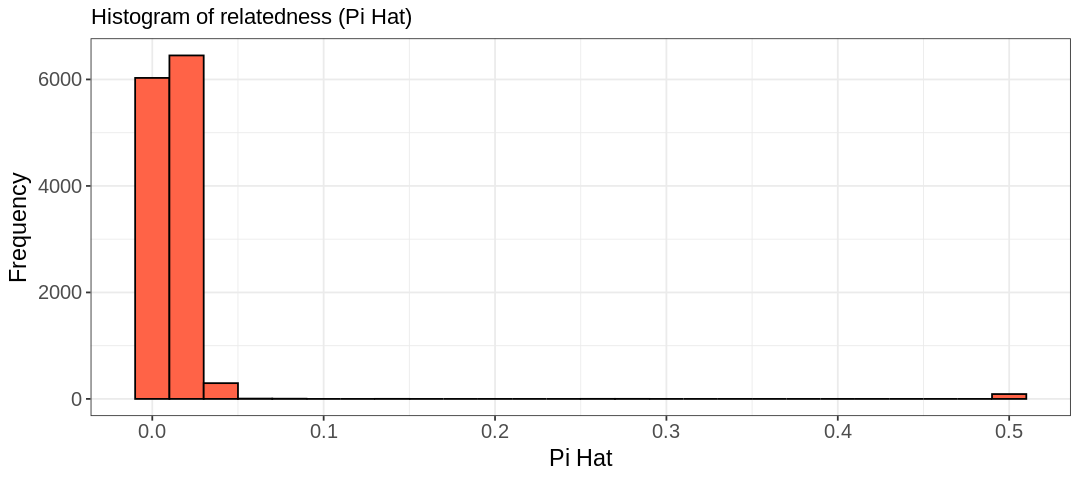

In [6]:
# Generate a plot to assess the type of relationship.
suppressMessages(suppressWarnings(library(ggplot2)))

options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
relatedness <- read.table("Results/GWAS4/pihat.genome", header=T)

# Relatedness plot
plot.relatedness <- ggplot(relatedness) +
  geom_point(aes(x=Z0, y=Z1, col=RT), size=5, alpha=.25) + 
  xlim(0,1) + 
  ylim(0,1) +
  labs(x = "Z0", y = "Z2", title = "Identity by descent probabilities", col = "Relationship") + 
  theme_bw() +
  theme(axis.title=element_text(size=14), axis.text=element_text(size=12))

# Relatedness histogram
hist.relatedness <- ggplot(relatedness, aes(x=relatedness[,10])) +
  geom_histogram(binwidth = 0.02, col = "black", fill="tomato") + 
  labs(title = "Histogram of relatedness (Pi Hat)") + 
  xlab("Pi Hat") + 
  ylab("Frequency") + 
  theme_bw() +
  theme(axis.title=element_text(size=14), axis.text=element_text(size=12))


show(plot.relatedness)
show(hist.relatedness)

The generated plots show some individuals in the HapMap data labeled as Parent-Offspring. You can observe a total of three categories: 

- UN (unrelated),
- PO (parent-offspring),
- and OT (other)

PO relationship has 100% prpobability of two alleles identical by descent, and mostly UN and OT samples are unrelated. Some UN samples are probably in some way related, maybe their relationship is not correctly recorded in the data.
  
The presence of related individuals is not a surprise, since the dataset was constructed to contain family trios and population structure to describe patterns of common genetic variation.

:::{.callout-important title="Stop - Read - Solve"}

Use `PLINK` options to filter out related individuals, using a relateness threshold of 0.2. Name the output `--out Results/GWAS4/pihat_exercise`. The command is similar to the one used at the beginning, but you need an extra option.

- How many individuals are related and filtered out? Hint: open the file `Results/GWAS4/pihat_exercise.log`. They are labeled as non-founders. 

Afterward, we will replot the z-values. 

- What relationship categories remain?

:::

<img src="Images/bash.png" alt="Bash" width="40">

In [2]:
# Write your code here (PLINK command)


:::{.callout-tip title="Solution"}

We need the option `--max 0.2` in PLINK so that only individuals below that threshold are used.

In [1]:
plink --bfile Results/GWAS3/HapMap_3_r3_7 --extract Results/GWAS3/indepSNP.prune.in --genome --out Results/GWAS4/pihat_exercise --max 0.2 --silent

If you look at the difference in number of lines in the filtered and unfiltered list of individuals, we removed 93 samples as expected.
  

In [5]:
wc -l Results/GWAS4/pihat.genome

12881 Results/GWAS4/pihat.genome


In [2]:
wc -l Results/GWAS4/pihat_exercise.genome

12788 Results/GWAS4/pihat_exercise.genome


<img src="Images/R.png" alt="R" width="40"> Let's plot the z-values again (repeating the plot from above)

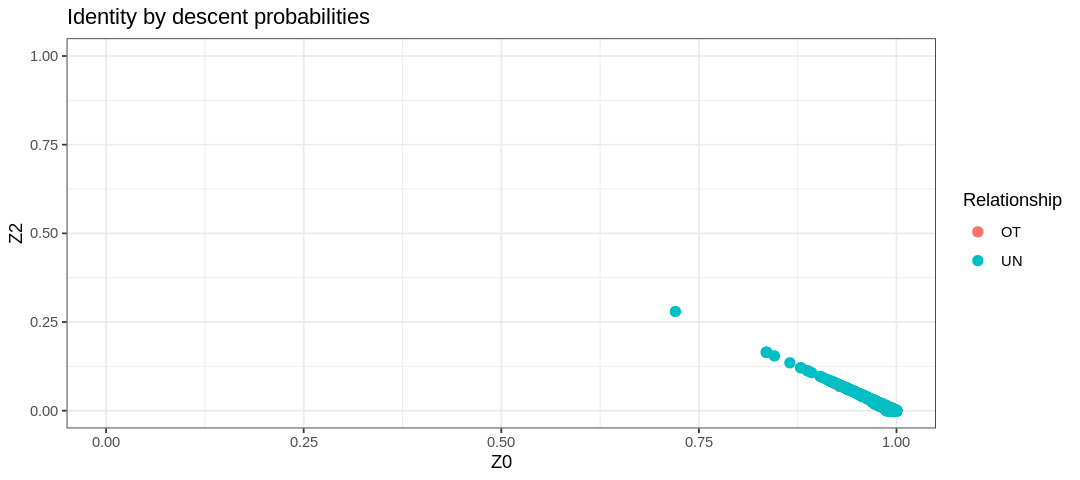

In [1]:
# Generate a plot to assess the type of relationship.
suppressMessages(suppressWarnings(library(ggplot2)))

options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
relatedness <- read.table("Results/GWAS4/pihat_exercise.genome", header=T)

# Relatedness plot
plot.relatedness <- ggplot(relatedness) +
  geom_point(aes(x=Z0, y=Z1, col=RT), size=2.5) + 
  xlim(0,1) + 
  ylim(0,1) +
  labs(x = "Z0", y = "Z2", title = "Identity by descent probabilities", col = "Relationship") + 
  theme_bw()

show(plot.relatedness)

There are only UN (unrelated) individuals left. 

***

<img src="Images/bash.png" alt="Bash" width="40"> Now, you have seen how to filter out through threshold the individuals in the exercise above. Below, we demonstrate that the majority of the relatedness was due to parent-offspring relationships, by exclusively including founders (individuals without parents in the dataset). This is done with the option `--filter-founders` to create `bed,bim,fam` files and then we create the `genome` file with relatedness values.

In [3]:
plink --bfile Results/GWAS3/HapMap_3_r3_7 --filter-founders --make-bed --out Results/GWAS4/HapMap_3_r3_8 --silent

plink --bfile Results/GWAS4/HapMap_3_r3_8 --extract Results/GWAS3/indepSNP.prune.in --genome --out Results/GWAS4/pihat_founders --silent

<img src="Images/R.png" alt="R" width="40"> We will now plot the results by using the `--filter-founders` option in PLINK. 


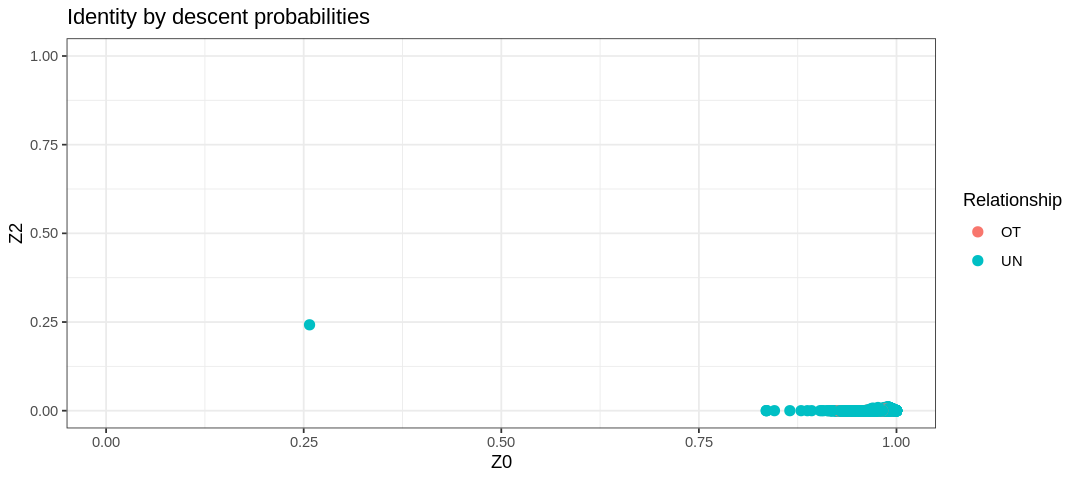

In [2]:
# Generate a plot to assess the type of relationship.
suppressMessages(suppressWarnings(library(ggplot2)))

options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
relatedness <- read.table("Results/GWAS4/pihat_founders.genome", header=T)

# Relatedness plot
plot.relatedness <- ggplot(relatedness) +
  geom_point(aes(x=Z0, y=Z2, col=RT), size=2.5) + 
  xlim(0,1) + 
  ylim(0,1) +
  labs(x = "Z0", y = "Z2", title = "Identity by descent probabilities", col = "Relationship") + 
  theme_bw()

show(plot.relatedness)

:::{.callout-important title="Stop - Read - Solve"}

Is there anything unexpected that you observe in the plot? 

:::

:::{.callout-tip title="Solution" collapse=true}

The file `pihat_founders.genome` shows that, after excluding all non-founders, one individual pair removed in the exercise remains in the HapMap data. Even if labeled as unrelated, it had a high relatedness.

:::

This remaining individual is likely to be a full sibling or DZ (dizygotic) twin pair based on the Z values (expected values for full siblings: z0=0.25; z1=0.50;  z2=0.25). Noteworthy, they were not given the same family identity (FID) in the HapMap data. Below, we can look at the individual from the table by setting $Z_0 < 0.5$.

In [3]:
relatedness[relatedness$Z0 < 0.5,]

,FID1,IID1,FID2,IID2,RT,EZ,Z0,Z1,Z2,PI_HAT,PHE,DST,PPC,RATIO
,<int>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
2639,13291,NA07045,1454,NA12813,UN,NA,0.2574,0.5005,0.2421,0.4923,0,0.839757,1,9.6694


We do not need to remove both individuals from the dataset (IID1= NA07045; IID2=NA12813). It suffices to remove only one, and the individual chosen for removal should have the highest missing rate. First we need to calculate missing rates with PLINK

In [1]:
plink --bfile Results/GWAS4/HapMap_3_r3_8 --missing --out Results/GWAS4/HapMap_3_r3_8 > /dev/null 

then we look at the two individuals from the output file using `grep` and sorting descendingly by missing rate (column 6)

In [2]:
# Let's look at the output
cat Results/GWAS4/HapMap_3_r3_8.imiss | grep -E 'NA07045|NA12813' | sort -k6,6nr

  13291   NA07045          N     2560  1073788 0.002384
   1454   NA12813          N     1956  1073788 0.001822


`NA07045` is the individual to be removed. Once this is removed, the offspring can be used only in analysis not involving trios (such as family-related analysis), but it still can be used for other studies.

:::{.callout-important title="Stop - Read - Solve"}

Use the `imiss` file to plot a histogram of the missing scores in `R` (you can use one of the previous notebooks for help) from the file `HapMap_3_r3_8.imiss`. Is the score of `NA07045` amongst the higher ones?

:::

:::{.callout-tip title="Solution"}

We can simply extract the column from the file, and we can see in the histogram how the `NA07045` individual has a missing rate tending to the higher values in the plot.

:::

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


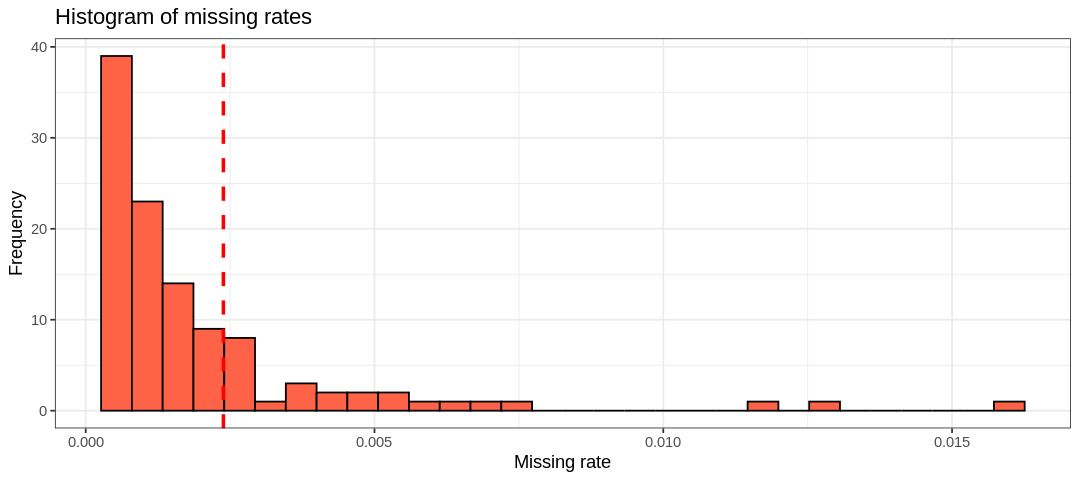

In [1]:
suppressMessages(suppressWarnings(library(ggplot2)))

options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
imiss <- read.table("Results/GWAS4/HapMap_3_r3_8.imiss", header=T)

hist.relatedness <- ggplot(data=imiss, aes(F_MISS)) +
  geom_histogram(col = "black", fill = "tomato") + 
  geom_vline(xintercept = 0.002384, color = "red", linetype = "dashed", size = 1) +
  labs(title = "Histogram of missing rates") + 
  xlab("Missing rate") + 
  ylab("Frequency") + 
  theme_bw()

show(hist.relatedness)

---

<img src="Images/bash.png" alt="Bash" width="40">  To remove the individual from the data, we create a file containing its number and ID, and provide it to PLINK with the option `--remove`

In [1]:
echo "13291  NA07045" > Results/GWAS4/parent_remove.txt

In [2]:
# Delete the individuals with the lowest call rate in 'related' pairs with a pihat > 0.2 
plink --bfile Results/GWAS4/HapMap_3_r3_8 --remove Results/GWAS4/parent_remove.txt --make-bed --out Results/GWAS4/HapMap_3_r3_9 --silent

## 4.2 Population Stratification

:::{.callout-note title="Some theory"}

Population stratification presents a significant source of systematic bias in GWAS, arising **when subpopulations exhibit systematic differences in allele frequencies** (e.g., the distribution of north and south European individuals in the PCA space and the height of those individuals). Research indicates that even subtle degrees of population stratification can exist within a single ethnic population [@abdellaoui2013population]. Thus, testing and controlling for the presence of population stratification is an essential QC step.
The population structure (or in other words, the ancestral relationship of the populations) is a so-called **confounding factor**. This means that it influences both the dependent and independent variables, as in the figure below, where both the genotype and the traits are influenced by the presence of population structure.

![](Images/ancestryBias.png){fig-align="center", width=400px}

Why is a bias introduced? Population structure can influence allele frequencies and therefore produce false positives/negatives when doing association testing. Graphically, consider the example in the figure below. Case and control have minor allele frequencies of 1/6 and 1/8 (population 1) and 1/2, 7/12 (population 2). If you remove population structure, Case and control have MAFs of 3/10, and 2/5, and those new values depend on how many samples you have from each population in the two conditions, and what are the MAFs of each populations. 

![](Images/popStruct.png){fig-align="center", width=400px}

The same problem arises in population studies without Case-control categories. Imagine having a population of randomly sampled individuals, each from a different ethnicity (the blue and red minor alleles in the example below). The final group of individuals will have a different proportion of MAFs depending on the sampling of various ethnicities.

![](Images/popSampling.png){fig-align="center", width=400px}

There are several methods to correct for population stratification [@price2010new, price_principal_2006]. In this tutorial, we illustrate a method integrated into PLINK: the **multidimensional scaling (MDS)** approach. MDS calculates the genome-wide average proportion of shared alleles between any pair of individuals within the sample to generate quantitative indices (components) of the genetic variation for each individual. **The individual component scores can be visualized to identify groups of genetically similar individuals.** For instance, in a genetic study including subjects from Asia and Europe, MDS analysis would reveal that Asians are genetically more similar to each other than to Europeans and Africans. Figure below shows another example of MDS using HapMap, Genome diversity project, and authors' own data:

![Example of MDS plot of the first two MDS components scores on integrated datasets in @somers_genetic_2017. Here TWN, a past isolated population in the Netherlands, is separated from the other individuals from the same country (NDL). Sardinians, notoriously different from continental Italians, are also grouped far away from them. Central European populations colocalize as expected.](./Images/MDSexample2.png){width=500px label=fig-MDSexample}

To investigate which individuals the generated component scores deviate from in the target population, plotting the scores of the sample under investigation and a population of known ethnic structure (e.g., HapMap/1KG data) is helpful: this step is called **anchoring** [@rietveld2013gwas]. This enables the researcher to obtain ethnic information on their sample and to determine possible ethnic outliers. For example, in @fig-MDSexample, if TSI (Tuscans from Italy) is the anchor population, one can hypothesize that the yellow dots might be ethnically similar (as they are in the example).

Outliers identified based on MDS analysis should be excluded from further analyses. Following their removal, a new MDS analysis must be conducted, and its primary components are utilized as covariates in association tests to correct for any residual population stratification within the population. The number of components to include depends on the population structure and sample size, with the psychiatric genetics community typically accepting the inclusion of up to 10 MDS components, for example. Below is an MDS from @cortellari_climatic_2021, where a population of goats stands out from all the other. The MDS capture very little population structure for all the other samples on the second axis, because this is dominated by the outlier population. Removing the outlier and rerunning the MDS provides a better view of the structure within the remaining populations.

![](./Images/MDSout1.png){width=400px}  ![](./Images/MDSout2.png){width=400px}

:::

:::{.callout-important title="Stop - Read - Solve"}

It is also possible to correct for relatedness (family structure). Should we do it in our study?

:::

### 4.2.1 Analysis

We want to look at the HapMap and 1000GP data merged into one dataset, anchoring HapMap against 1000GP. As a result, we want to see if the HapMap data's ethnicity can be detected by looking at the 1000GP's data ethnicities. There are a lot of steps to unpack to make the two datasets compatible, so hold tight!

#### 1000GP data download

Below, we show some commands to download the 1000GP data and convert it into the file formats for GWAS analysis. You do not need to run those commands as we already did it before and it takes some time.

First, we need to download the 1000 Genomes genetic data for our HapMap data to be anchored against. This file from the 1000 Genomes contains genetic data of 629 individuals from different ethnic backgrounds.
Note, this file is quite large (>60 gigabyte). You can do so with the following bash command:

```{.bash}
wget ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20100804/ALL.2of4intersection.20100804.genotypes.vcf.gz

The data can then be converted from the `vcf` file (Variant Call Format) into format readable with plink (`bim`,`fam`, `bed`):

```{.bash}
plink --vcf ALL.2of4intersection.20100804.genotypes.vcf.gz --make-bed --out ALL.2of4intersection.20100804.genotypes
```

:::{.callout-note}

The 1000 Genomes data downloaded above is rather large and we have commented out those commands, so that they are shown as reference, and will not actually run when you execute them. To save time, we have supplied the `.bed`, `.bim`and `.fam` files in the `Data` folder.

:::

Let's unzip the files and see how many samples we have. There should be 37.

In [3]:
unzip -o Data/1000genomes.zip -d Results/GWAS4
wc -l Results/GWAS4/1000genomes.genotypesA.fam

Archive:  Data/1000genomes.zip
  inflating: Results/GWAS4/1000genomes.genotypesA.bed  
  inflating: Results/GWAS4/1000genomes.genotypesA.bim  
  inflating: Results/GWAS4/1000genomes.genotypesA.fam  
  inflating: Results/GWAS4/1000genomes.genotypesA.log  
  inflating: Results/GWAS4/1000genomes.genotypesA.nosex  
37 Results/GWAS4/1000genomes.genotypesA.fam


One should note that the file `1000genomes.genotypes.bim` contains SNPs without an rs-identifier (or Reference SNP cluster ID): 

In [5]:
cat Results/GWAS4/1000genomes.genotypesA.bim | head -5

1	rs112750067	0	10327	C	T
1	.	0	11508	A	G
1	.	0	12783	G	A
1	.	0	13116	G	T
1	.	0	14933	A	G


The missing rs-identifiers in the 1000 Genomes data are not a problem for this tutorial. However, for good practice, we will assign unique indentifiers to the SNPs with a missing rs-identifier (the SNPs with id `.`):

In [6]:
plink --bfile Results/GWAS4/1000genomes.genotypesA --set-missing-var-ids @:#[b37]\$1,\$2 --make-bed --out Results/GWAS4/1000genomes.genotypesA_no_missing_IDs --silent

Now we can visualize the data again and see which names have been assigned to the SNPs. Those come from the bunch of symbol `@:#[b37]\$1,\$2` in the command above, which is read by plink as `chromosome:locus[b37]Allele1,Allele2`. Look at what you have got with the renaming, and you will see what it means in practice:

In [7]:
# Show changes on the bim file
cat Results/GWAS4/1000genomes.genotypesA_no_missing_IDs.bim | head -5

1	rs112750067	0	10327	C	T
1	1:11508[b37]A,G	0	11508	A	G
1	1:12783[b37]A,G	0	12783	G	A
1	1:13116[b37]G,T	0	13116	G	T
1	1:14933[b37]A,G	0	14933	A	G


Pretty neat, right?

#### QC on 1000GP data

Before we merge the 1000 Genomes and HapMap datasets, we need to apply some QC on our 1000 Genomes data. As we previously in the GWAS3 notebook, we need to take into consideration missingness, sex discrepancy, and minor allele frequency. We put some standard thresholds and run everything below

In [8]:
plink --bfile Results/GWAS4/1000genomes.genotypesA_no_missing_IDs --geno 0.02  \
    --allow-no-sex --make-bed --out Results/GWAS4/1kG_MDS --silent

plink --bfile Results/GWAS4/1kG_MDS --mind 0.02  \
    --allow-no-sex --make-bed --out Results/GWAS4/1kG_MDS2 --silent
    
plink --bfile Results/GWAS4/1kG_MDS2 --maf 0.05 --allow-no-sex --make-bed  --out Results/GWAS4/1kG_MDS3 --silent

#### SNPs matching between datasets

We want to only consider SNPs that both datasets have in common. 

So for each dataset, we extract those that are present in the other. Furthermore, they must have the same genomic build so that they can be merged later

First, we extract SNP names from the HapMap data, and reduce the 1000GP data so that only those SNPs are considered, when present.

In [9]:
#Print out SNPs from the HapMap data
awk '{print$2}' Results/GWAS4/HapMap_3_r3_9.bim > Results/GWAS4/HapMap_SNPs.txt

#Extract the HapMap SNPs from the 1000GP data
plink --bfile Results/GWAS4/1kG_MDS3 --extract Results/GWAS4/HapMap_SNPs.txt \
--make-bed --out Results/GWAS4/1kG_MDS4 > /dev/null

This is how part of the list of SNP names looks like:

In [10]:
cat Results/GWAS4/HapMap_SNPs.txt | head -5

rs3131972
rs3131969
rs1048488
rs12562034
rs12124819


Now we take the variants from the reduced 1000GP data, and go the other way around. We extract 1000GP variants from the HapMap data. In other words, the two extraction passages will intersect the SNPs. Below is the code to use the SNPs of the 1000GP data to reduce the HapMap data.

In [11]:
#Print out SNPs from the HapMap data
awk '{print$2}' Results/GWAS4/1kG_MDS4.bim > Results/GWAS4/1kG_MDS4_SNPs.txt

#Extract the HapMap SNPs from the 1000GP data
plink --bfile Results/GWAS4/HapMap_3_r3_9 --extract Results/GWAS4/1kG_MDS4_SNPs.txt --recode \
--make-bed --out Results/GWAS4/HapMap_MDS --silent

Look at the SNP names. Now they are matching between the two `bim` files.

:::{.callout-important title="Stop - Read - Solve"}

Look the two outputs a bit more carefully? What is the problem?

:::

In [13]:
head Results/GWAS4/HapMap_MDS.bim

1	rs3131969	0	744045	A	G
1	rs12562034	0	758311	A	G
1	rs4970383	0	828418	A	C
1	rs4475691	0	836671	T	C
1	rs1806509	0	843817	C	A
1	rs28576697	0	860508	C	T
1	rs3748595	0	877423	A	C
1	rs13303118	0	908247	G	T
1	rs1891910	0	922320	A	G
1	rs3128097	0	970323	G	A


In [14]:
head Results/GWAS4/1kG_MDS4.bim

1	rs3131969	0	754182	A	G
1	rs12562034	0	768448	A	G
1	rs4970383	0	838555	A	C
1	rs4475691	0	846808	T	C
1	rs1806509	0	853954	A	C
1	rs28576697	0	870645	C	T
1	rs3748595	0	887560	A	C
1	rs13303118	0	918384	T	G
1	rs1891910	0	932457	A	G
1	rs3128097	0	980460	G	A


#### Build matching

Genomics data is created starting from a reference genome. The two datasets we are using have been created with two different versions of the human reference. This is not uncommon, as the human reference genome gets better and better over time, and is updated periodically on the online archives. But this also implies that the SPNs will be at different positions when comparing datasets arising from different reference genomes.

Here, we extract the SNP names and their positions along the genome for the HapMap data, and match the 1000GP data to the extracted SNPs, using the `--update-map` option in PLINK.

In [15]:
#Extract the HapMap variant coordinates
awk '{print$2,$4}' Results/GWAS4/HapMap_MDS.map > Results/GWAS4/buildhapmap.txt

This is how the list of SNPs look like:

In [18]:
cat Results/GWAS4/buildhapmap.txt | head -5

rs3131969 744045
rs12562034 758311
rs4970383 828418
rs4475691 836671
rs1806509 843817


Now we execute PLINK (there is a warning because positions are not all in ascending orders after changing their positions, but no worries) and update the variants coordinates of the 1000GP data based on the HapMap variants coordinates

In [17]:
plink --bfile Results/GWAS4/1kG_MDS4 --update-map Results/GWAS4/buildhapmap.txt --make-bed \
--out Results/GWAS4/1kG_MDS5 --silent

#### Merging datasets and performing MDS

Now, it is finally time for the last steps before merging the HapMap and 1000 Genomes datasets.

Before merging 1000 Genomes data with the HapMap data we want to make sure that the files are mergeable. For this, we conduct 3 steps:

1) Ensure the reference genome is similar in the HapMap and the 1000 Genomes Project datasets.  
2) Resolve strand issues, i.e. give SNPs the same orientation across datasets.  
3) Remove the SNPs which after the previous two steps still differ between datasets.  

The following steps may maybe quite technical in terms of commands, but we simply compare the two data sets and make sure they correspond:

**1.** We have previously matched the SNP positions in the two datasets, but we should also have the same reference alleles to be sure there is concordance of reference genomes. Below, we generate a list of SNPs and reference alleles from 1000GP data, which we then assign to the HapMap data with the `--reference-allele` option

In [18]:
#Extract variant coordinates and reference alleles from 1000GP data
awk '{print$2,$5}' Results/GWAS4/1kG_MDS5.bim > Results/GWAS4/1kg_ref-list.txt

How the list looks like:

In [19]:
head -5 Results/GWAS4/1kg_ref-list.txt

rs3131969 A
rs12562034 A
rs4970383 A
rs4475691 T
rs1806509 A


We can now run PLINK to assign the reference alleles to the HapMap dataset. We use `&> /dev/null` to redirect a lot of warning messages away from the screen

In [21]:
plink --bfile Results/GWAS4/HapMap_MDS --reference-allele Results/GWAS4/1kg_ref-list.txt --make-bed \
--out Results/GWAS4/HapMap-adj &> /dev/null

**2.** To resolve strand issues, we need to eventually flip SNPs which are found in both datasets and have complementary alleles. This would mean that such SNPs have been reported on the forward and the reverse strand (or viceversa). We need to identify those SNPs and then flip them in one of the two datasets. We generate lists of SNP names and alleles for the 1000GP and HapMap data, and visualize the SNPs which are unique. A SNP which is unique but reports alleles differently will show twice. Below you can see three example SNPs from the two files (the first SNP being from 1000GP data, and the second from HapMap data, which is also the data from which we have the reference alleles).

In [22]:
awk '{print$2,$5,$6}' Results/GWAS4/1kG_MDS5.bim > Results/GWAS4/1kGMDS5_tmp
awk '{print$2,$5,$6}' Results/GWAS4/HapMap-adj.bim > Results/GWAS4/HapMap-adj_tmp
sort Results/GWAS4/1kGMDS5_tmp Results/GWAS4/HapMap-adj_tmp |uniq -u > Results/GWAS4/all_differences.txt

In [23]:
head -6 Results/GWAS4/all_differences.txt

rs10006274 C T
rs10006274 G A
rs1008660 A G
rs1008660 T C
rs10088098 C T
rs10088098 G A


Consider the reference genome for the 1000GP data, and look specifically at the first locus reported above. The reference shows allele C (code below). This means that, when reporting C/T, the SNP is reported on the forward strand in the 1000GP data, while in the HapMap data, the SNP is reported on the reverse strand with G/T.

In [29]:
grep rs10006274 Results/GWAS4/1kg_ref-list.txt

rs10006274 C


:::{.callout-important title="Stop - Read - Solve"}

Look at the other two SNPs `rs1008660` and `rs10088098`. Is it always the same dataset which must be flipped? 

:::

:::{.callout-tip title="Solution" collapse=true}

If we print out the SNPs from the reference, we find out that `rs1008660` is `T`, which is reported as `T/C` in the 1000GP data. This means that such SNP will not be flipped. Thus HapMap and 1000GP data will differ at that SNP, which will need to be removed later.

In [30]:
cat Results/GWAS4/1kg_ref-list.txt | grep rs1008660

rs1008660 T
rs10086609 C
rs10086608 A


In [31]:
cat Results/GWAS4/1kg_ref-list.txt | grep rs10088098

rs10088098 C


:::

---

Now we take only the SNP names and give them to PLINK (option `--flip`), together with the reference genome (option `--reference-allele`)

In [32]:
## Flip SNPs for resolving strand issues.
# Print SNP-identifier and remove duplicates.
awk '{print$1}' Results/GWAS4/all_differences.txt | sort -u > Results/GWAS4/flip_list.txt

These are some of the SNP names

In [33]:
head -5 Results/GWAS4/flip_list.txt

rs10006274
rs1008660
rs10088098
rs1011297
rs1023098


Apply the flipping

In [34]:
plink --bfile Results/GWAS4/HapMap-adj --flip Results/GWAS4/flip_list.txt --reference-allele Results/GWAS4/1kg_ref-list.txt \
--make-bed --out Results/GWAS4/corrected_hapmap &> /dev/null

Notice how this SNP has changed

In [35]:
cat Results/GWAS4/corrected_hapmap.bim | grep rs10006274

4	rs10006274	0	124165369	C	T


In [36]:
cat Results/GWAS4/HapMap-adj.bim | grep rs10006274

4	rs10006274	0	124165369	G	A


But not this one, as we predicted!

In [38]:
cat Results/GWAS4/corrected_hapmap.bim | grep rs1008660

7	rs1008660	0	141791880	T	C
8	rs10086609	0	91925330	C	G
8	rs10086608	0	128556704	A	G


In [37]:
cat Results/GWAS4/HapMap-adj.bim | grep rs1008660

7	rs1008660	0	141791880	A	G
8	rs10086609	0	91925330	C	G
8	rs10086608	0	128556704	A	G


:::{.callout-note}

You can try to flip the 1000GP data as well, but this is not necessary, since this should already be made accordingly to the reference genome, and the orientations have been made to match on the HapMap data.

:::

**3.** After flipping SNPs, some of them will have now same orientation but different alleles when comparing datasets to each other (e.g. SNP `rs1008660`). Such SNPs have to be removed to avoid inferring data structure that is not there. Below, we get the SNPs from the corrected HapMap data, and visualize the unique SNP names together with the ones from the 1000GP data.

In [39]:
awk '{print$2,$5,$6}' Results/GWAS4/corrected_hapmap.bim > Results/GWAS4/corrected_hapmap_tmp

sort Results/GWAS4/1kGMDS5_tmp Results/GWAS4/corrected_hapmap_tmp | uniq -u  > Results/GWAS4/uncorresponding_SNPs.txt

we can read twice has a different allele representation after flipping

In [40]:
head -6 Results/GWAS4/uncorresponding_SNPs.txt

rs11524965 T C
rs11524965 T G
rs12646999 G A
rs12646999 G T
rs17114359 C A
rs17114359 C T


We extract only the SNP names from the file above, and exclude those using the PLINK option `--exclude` on both datasets

In [41]:
awk '{print$1}' Results/GWAS4/uncorresponding_SNPs.txt | sort -u > Results/GWAS4/SNPs_for_exclusion.txt

plink --bfile Results/GWAS4/corrected_hapmap --exclude Results/GWAS4/SNPs_for_exclusion.txt \
--make-bed --out Results/GWAS4/HapMap_MDS3 --silent
plink --bfile Results/GWAS4/1kG_MDS5 --exclude Results/GWAS4/SNPs_for_exclusion.txt \
--make-bed --out Results/GWAS4/1kG_MDS6 --silent

**5.** We merge the data and look at MDS. We provide the dataset to begin with (`--bmerge` option), and the one to add (`-bfile`).

In [42]:
plink --bfile Results/GWAS4/corrected_hapmap --bmerge Results/GWAS4/1kG_MDS6.bed Results/GWAS4/1kG_MDS6.bim Results/GWAS4/1kG_MDS6.fam \
--allow-no-sex --make-bed --out Results/GWAS4/MDS_merge --silent

MDS is usually used on SNPs that are independent of each other. We already have this list from earlier in this course, so we extract only these SNPs.

In [43]:
plink --bfile Results/GWAS4/MDS_merge --extract Results/GWAS3/indepSNP.prune.in \
    --genome --out Results/GWAS4/MDS_merge2 --silent

Now we can use PLINK to run MDS with the option `---mds-plot` giving the number of components to calculate.

In [44]:
# mds-plot
plink --bfile Results/GWAS4/MDS_merge2 --read-genome Results/GWAS4/MDS_merge2.genome \
    --cluster --mds-plot 10 --out Results/GWAS4/MDS_merge2 --silent

We download the panel of individual names and population from the 1000GP. This contains population names from which each individual comes from.

In [45]:
wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20100804/20100804.ALL.panel -P Results/GWAS4 -q

We merge the 1000GP population names with the ones for the HapMap data, which we label `OWN`, assuming we are trying to determine which population the HapMap individuals come from

In [46]:
awk '{print$1,$2,"OWN"}' Results/GWAS4/HapMap_MDS.fam > Results/GWAS4/racefile_own.txt
awk '{print$1,$1,$2}' Results/GWAS4/20100804.ALL.panel > Results/GWAS4/20100804.ALL.panel.txt

cat <(echo "FID IID race") Results/GWAS4/20100804.ALL.panel.txt Results/GWAS4/racefile_own.txt > Results/GWAS4/racefile.txt

<img src="Images/R.png" alt="R" width="40"> After all the many steps above we can visualize population stratification using multidimensional scaling (MDS) technique. The 1000GP used as anchor is mixed with the HapMap data around the central european (CEU), Tuscany (TSI), Spanish Iberian (IBS), British (GBR) and finnish (FIN) populations. This confirms what we know, i.e. that HapMap data is composed of european individuals. We can also see that there are not points located far away from all the others, meaning there are not outliers in the HapMap data.

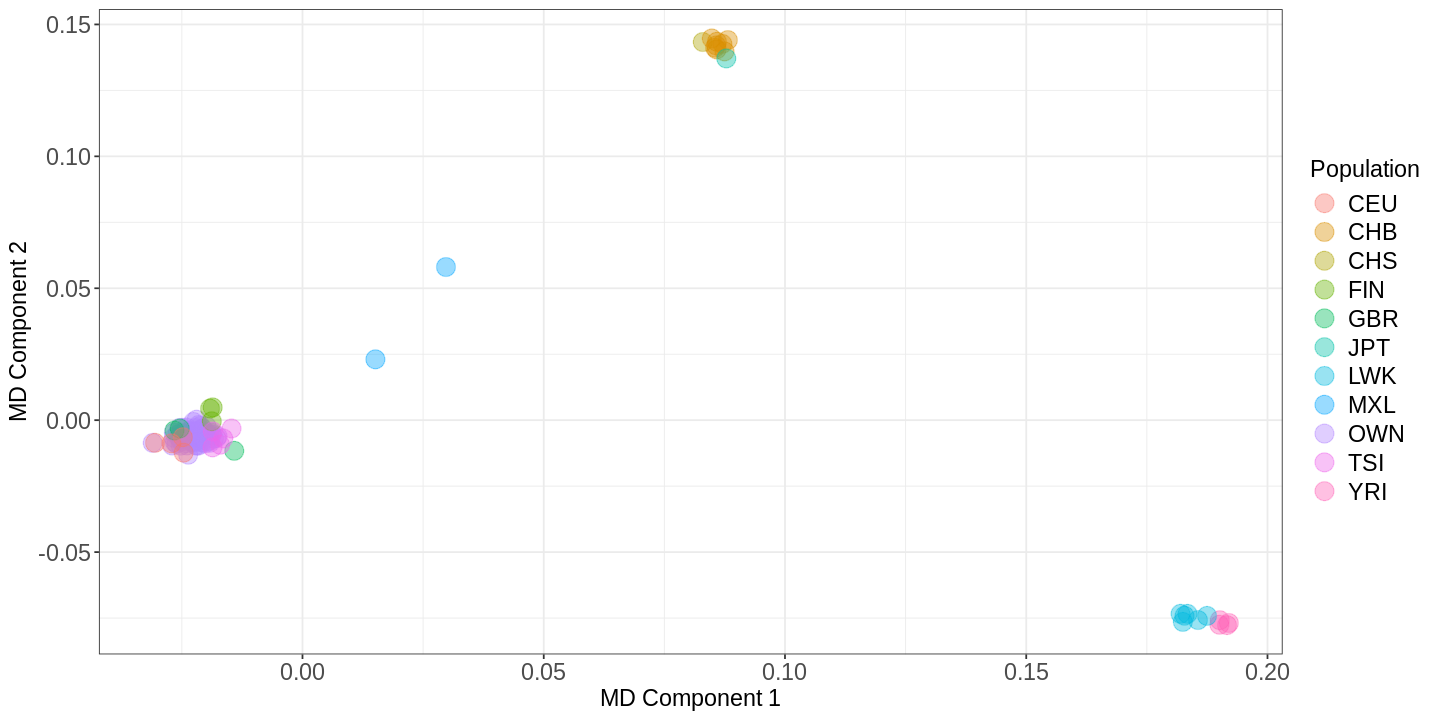

In [3]:
options(repr.plot.width = 12, repr.plot.height = 6)

suppressMessages(suppressWarnings(library(ggplot2)))

# Read data into R 
data <- read.table(file="Results/GWAS4/MDS_merge2.mds",header=TRUE)
race <- read.table(file="Results/GWAS4/racefile.txt",header=TRUE)
datafile <- merge(data,race,by=c("FID","IID"))

scatter.mds <- ggplot(datafile, aes(x=C1, y=C2, color=race)) +
  geom_point(size=5, alpha=.4) +
  xlab("MD Component 1") + 
  ylab("MD Component 2") +
  labs(color="Population") +
  theme_bw() +
  theme(axis.title = element_text(size = 14), legend.text = element_text(size = 14), 
        axis.text = element_text(size = 14), legend.title=element_text(size=14))
  
show(scatter.mds)

:::{.callout-note}

The 1000GP is organized in large populations (europeans, africans, chinese, ...) for which there are subpopulations as seen in the previous figure. You can see all populations listed in the table below.

![](./Images/1000GP.png){width=800px}

:::

#### Exclude ethnic outliers

Even though we have not found outliers in the MDS plot, let's assume there was an outlier in the lower left corner of the plot, and that we want to remove it.

<img src="Images/bash.png" alt="Bash" width="40"> The script below remove any individual falling in the MDS plot area such that MD component 1 < 0 and MD component 2 <-0.05. The MDS file looks like below (first 3 rows), and it shows MDS components from the fourth column

In [1]:
head -3 Results/GWAS4/MDS_merge2.mds | cut -f1-6 -d$'\t'

    FID       IID    SOL           C1           C2           C3           C4           C5           C6           C7           C8           C9          C10 
   1328   NA06984      0   -0.0218368  -0.00620683  -0.00464884   0.00121512 -0.000413235   0.00221093    0.0104188  -0.00199382    0.0173257   -0.0131241 
   1328   NA06989      0   -0.0208157  -0.00581126  -0.00638572   0.00503345  -0.00116741  -0.00369152    0.0120005   -0.0229035  -0.00238946    0.0381386 


The selection has to be done for the individuals we want to keep, so the area to be chosen has to be mirrored into >0 and >-0.05. We provide the MDS component values in column 4 and 5 of the file, and extract the individuals using `--keep` 

In [2]:
awk '{ if ($4 >0 || $5 >-0.05) print $1,$2 }' Results/GWAS4/MDS_merge2.mds > Results/GWAS4/EUR_MDS_merge2

plink --bfile Results/GWAS4/HapMap_3_r3_9 --keep Results/GWAS4/EUR_MDS_merge2 --make-bed  \
--out Results/GWAS4/HapMap_3_r3_10 > /dev/null

#### Creating covariates for GWAS analysis

Now, we run again MDS on the data from which ethnic outliers have been excluded. The steps below are the same already used for calculating MDS. In addition, we want to create a covariate file for PLINK. This is needed to correct for population stratification in our data in the next tutorial notebook, when the covariates will be included in the regression. The covariate file is simply the MDS output file, from which we need to remove column 3 (SOL, which is a piece of optional metadata information).

In [3]:
plink --bfile Results/GWAS4/HapMap_3_r3_10 --extract Results/GWAS3/indepSNP.prune.in --genome  \
--out Results/GWAS4/HapMap_3_r3_10 > /dev/null
plink --bfile Results/GWAS4/HapMap_3_r3_10 --read-genome Results/GWAS4/HapMap_3_r3_10.genome \
--cluster --mds-plot 10 --out Results/GWAS4/HapMap_3_r3_10_mds > /dev/null

# Change the format of the .mds file into a plink covariate file.
awk '{print $1, $2, $4, $5, $6, $7, $8, $9, $10, $11, $12, $13}' Results/GWAS4/HapMap_3_r3_10_mds.mds > Results/GWAS4/covar_mds.txt

The values in `covar_mds.txt` will be used as covariates to adjust for remaining population stratification in the third tutorial, where we will perform a genome-wide association analysis. Look at the file preview below with the ten components of the MDS projection:

In [5]:
head -5 Results/GWAS4/covar_mds.txt

FID IID C1 C2 C3 C4 C5 C6 C7 C8 C9 C10
1328 NA06989 0.0193503 -0.0481539 0.053743 -8.56966e-05 0.0124037 -0.00872553 0.0146577 -0.0266013 0.0064429 -0.0149862
1377 NA11891 0.0105154 -0.0241653 -0.00713715 -0.0276522 0.0272997 0.0044621 -0.00373271 -0.00561896 -0.0317101 0.0188078
1349 NA11843 -0.00217144 0.0120046 -0.00508388 0.0193558 -0.00738542 0.0285001 -0.00512723 0.00271516 0.0029428 0.000145191
1330 NA12341 -0.0124555 -0.0114929 0.0019162 -0.0252928 -0.0300722 -0.00411769 -0.0207568 -0.0122574 -0.017065 0.0353729


:::{.callout-note title="Wrapping up"}

You have now successfully checked your data for relatedness population stratification. You filtered out the individuals with high relatedness and produced a summary of the population structure using the MDS projection. You will use the MDS coordinates as a proxy for the population structure you want your association testing to be corrected for.  

In the next notebook on **Association Testing**, you will need the following files from the folder `Results/GWAS4/`:
- `HapMap_3_r3_10` (the bfile, i.e., `HapMap_3_r3_10.bed`, `HapMap_3_r3_10.bim`, and `HapMap_3_r3_10.fam`)
- `covar_mds.txt`
which are the HapMap data and the MDS covariates highlighting the population stratification. Those are already available once you have been running this notebook.

Below is a cheat sheet of our new methods of QC. Again, it is important to remember that each method of QC should be justified, which will depend on the nature of the feature you are trying to analyze.


| Step| Command| Function| Thresholds and explanation|
|------------------------------|------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 6: Relatedness| --genome| Calculates identity by descent (IBD) of all sample pairs.| Use independent SNPs ( pruning) for this analysis and limit it to autosomal chromosomes only.|
| - | --min| Sets threshold and creates a list of individuals with relatedness above  the chosen threshold. This means that subjects who are related at, for  example, pi‐hat >0.2 (i.e., second-degree relatives) can be detected. | Cryptic relatedness can interfere with the association analysis. If you  have a family‐based sample (e.g., parent‐offspring), you do not need to  remove related pairs but the statistical analysis should take family  relatedness into account. However, for a population-based sample, we suggest using a pi‐hat threshold of 0.2, which is in line with the literature (Anderson et al.,  2010; Guo et al.,  2014). |
| 7: Population Stratification | --genome | Calculates identity by descent (IBD) of all sample pairs.| Use independent SNPs ( pruning) for this analysis and limit it to autosomal chromosomes only.|
| - | --cluster --mds-plot k | Produces a  k‐dimensional representation of any substructure in the data, based on IBS.| K is the number of dimensions, which needs to be defined  (typically 10). This is an important step of the QC that consists of  multiple proceedings but for reasons of completeness, we briefly refer to  this step in the table. This step will be described in more detail in the section “Controlling for population stratification.”|



:::

# Bibliography